# Master Modeler Competition Jupyter Notebook (Laird Stewart/Joey Hodson)

### Importing modules

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
import seaborn as sn
from sklearn import linear_model
from sklearn import metrics

import nltk # python natural language toolkit
nltk.download('vader_lexicon') # Vader lexicon for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer # vader sentiment analyzer

pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'shap'

### Importing Data

In [3]:
df_original = pd.read_csv('master_model.csv')
df_original.head()

,company,date,type,URL,text,total engagement,engagement rate,reactions,shares,comments
0,ERASE (US),"06 Feb, 2020 13:09",photo,https://www.facebook.com/1003344626383879/post...,#Missing\n#HelpFindGeorgia\n#pleaseshare,4057,8595.338983,292,3745,20
1,ERASE (US),"11 Oct, 2017 11:13",photo,https://www.facebook.com/helperase/posts/16287...,FB Community we need your help! Please share t...,1083,5455.919395,32,1030,21
2,ERASE (US),"27 Jul, 2020 6:25",photo,https://www.facebook.com/1003344626383879/post...,_ôî«_ôî«Recovered and Safe _ôî«_ôî«\nIf you ha...,856,1807.050876,12,840,4
3,ERASE (US),"17 Jul, 2019 19:27",link,https://www.facebook.com/1003344626383879/post...,#Missing\n#Michigan\n#pleaseshare,817,2269.444444,64,751,2
4,ERASE (US),"08 Mar, 2019 21:52",link,https://www.facebook.com/1003344626383879/post...,NaN,752,2354.414527,50,701,1


### Data Exploration

In [4]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           2400 non-null   object 
 1   date              2400 non-null   object 
 2   type              2400 non-null   object 
 3   URL               2392 non-null   object 
 4   text              2136 non-null   object 
 5   total engagement  2400 non-null   int64  
 6   engagement rate   2400 non-null   float64
 7   reactions         2400 non-null   int64  
 8   shares            2400 non-null   int64  
 9   comments          2400 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 187.6+ KB


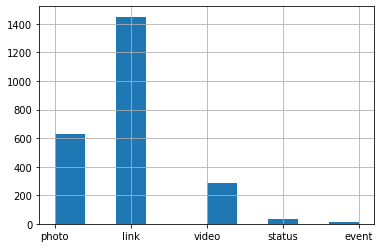

In [5]:
df_original['type'].hist()

In [6]:
df_original[['total engagement','engagement rate', 'reactions','shares','comments']].mean()

total engagement     28.837083
engagement rate     106.261380
reactions            13.742500
shares               14.171667
comments              0.922917
dtype: float64

In [7]:
df_original[['total engagement','engagement rate', 'reactions','shares','comments']].median()

total engagement    12.000000
engagement rate     54.953937
reactions            8.000000
shares               4.000000
comments             0.000000
dtype: float64

### Data Cleaning

In [8]:
df0 = df_original.copy()

# create datetime objects (for easier analysis)
df0['date'] = pd.to_datetime(df0['date'])

# sort by date 
df0 = df0.sort_values(by='date')

# drop 'company' tag
df1 = df0.drop(['company', 'URL'],axis=1)

# #  create binary dummy variables for "type"
dummy = pd.get_dummies(df1['type'])
df2 = df1.merge(dummy, left_index=True, right_index=True)
df3 = df2.drop(['type'],axis=1)

# replace NaN values with "" in text (need to do this before counting hashtags)
df3['text'] = df3['text'].fillna("")

### Extracting Text Features 1 (hashtags)

In [9]:
# number of hashtags
df3['hashtags'] = df3['text'].map(lambda x: len(re.findall('\#',x)))

### Text Cleaning

In [10]:
# replace \n with " " in 'text'
df3['text'] = df3['text'].map(lambda x: re.sub('\n',' ',x))

# remove non standard text charachters in 'text'
df3['text'] = df3['text'].map(lambda x: re.findall(r"[A-Za-z!.,']\s*",x)) # turns text into a list of hits
df3['text'] = df3['text'].map(lambda x: "".join(x)) # turn list of hits back into string

# turn multiple spaces into single spaces
df3['text'] = df3['text'].map(lambda x: re.sub('\s+',' ', x))

# replace any aA with a A 
df3['text'] = df3['text'].map(lambda x: re.sub(r"([a-z])([A-Z])", r"\1 \2", x))

### Extracting Text Features 2 (length, sentiment)

In [11]:
# length of post
df3['length'] = df3['text'].map(lambda x: len(x))

# sentiment score
sid = SentimentIntensityAnalyzer()
df3['sentiment'] = df3['text'].map(lambda x: sid.polarity_scores(x).get('compound'))

### Extracting Date/Time Features

In [12]:
# Season
df3['spring'] = df3['date'].map(lambda x: 1 if (x.month in (3,4,5) ) else 0)
df3['fall'] = df3['date'].map(lambda x: 1 if (x.month in (9,10,11) ) else 0)
df3['summer'] = df3['date'].map(lambda x: 1 if (x.month in (6,7,8) ) else 0)
df3['winter'] = df3['date'].map(lambda x: 1 if (x.month in (12,1,2) ) else 0)

# Time of day (morning, afternoon, night)
df3['morning'] = df3['date'].map(lambda x: 1 if (x.hour in range (0, 13) ) else 0)
df3['afternoon'] = df3['date'].map(lambda x: 1 if (x.hour in range (13, 18) ) else 0)
df3['night'] = df3['date'].map(lambda x: 1 if (x.hour in range (18, 24) ) else 0)

# Day of week
df3['monday'] = df3['date'].map(lambda x: 1 if (x.weekday() == 0 ) else 0)
df3['tuesday'] = df3['date'].map(lambda x: 1 if (x.weekday() == 1 ) else 0)
df3['wednesday'] = df3['date'].map(lambda x: 1 if (x.weekday() == 2 ) else 0)
df3['thursday'] = df3['date'].map(lambda x: 1 if (x.weekday() == 3 ) else 0)
df3['friday'] = df3['date'].map(lambda x: 1 if (x.weekday() == 4 ) else 0)
df3['saturday'] = df3['date'].map(lambda x: 1 if (x.weekday() == 5 ) else 0)
df3['sunday'] = df3['date'].map(lambda x: 1 if (x.weekday() == 6 ) else 0)

### Calculating views

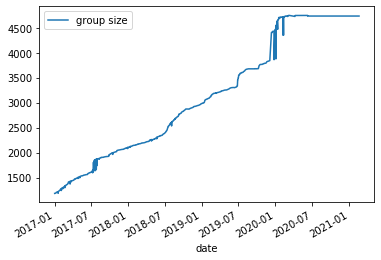

In [13]:
# engagement rate  = ((total engagement) / (Total who could see it) )* 100
# --> total who could see it = total engagement * 10,000 / engagement rate 
df4 = df3.copy()
df4['engagement rate'] = df3['engagement rate'] / 100 # proper percentage out of 100 (mentioned this in video)
df4['group size'] = (df4['total engagement'] / df4['engagement rate']) * 100 

# note, some values of engagement rate are 0, this gives NaN. Replace with next valid entry (size doesn't change that much week to week)
df4['group size'] = df4['group size'].fillna(method='ffill')
# df4['group size'] = df4['group size'].fillna(0)  # alternative to show this worked

# line plot of group size to make sure this worked properly (it does)
ax = df4[['group size', 'date']].plot.line(x='date')

### Scoring based on metrics

In [14]:
# calculate a score where share is 50x as valuable as a reaction and comment is 10x 
df4['score'] = (df4['reactions'] + 10*df4['comments'] + 50*df4['shares']) / df4['group size']

### Feature Scaling

In [148]:
# log scale and normalize score
df4['log score'] = np.log(df4['score'] + 1) # +1 to avoid issues with log(0)
df4['norm log score'] = (df4['log score'] - min(df4['log score']))/(max(df4['log score']) - min(df4['log score']))
# normalize length 
df4['norm length'] = df4['length'] / max(df4['length'])

# normalize sentiment 
df4['norm sentiment'] = (df4['sentiment'] - min(df4['sentiment']))/(max(df4['sentiment']) - min(df4['sentiment']))

# normalize hastags 
df4['norm hashtags'] = df4['hashtags'] / max(df4['hashtags'])


### Multiple Linear Regression

In [150]:
# Creating Features(X) and Output (Y\Y0) datasets for training regression models
X = df4[['event','link','photo','status','video','spring', 'fall', 'summer', 'winter', 'morning', 'afternoon', 'night', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'norm length', 'norm sentiment', 'norm hashtags']]
Y = df4[['norm log score']]
Y0 = Y.values.ravel()

### Random Forest Regression

In [118]:
# define the model
rfr = RandomForestRegressor()
# fit the model, Hyperparamater turning was tested with no significant changes in feature importance found
rfr.fit(X, Y0)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

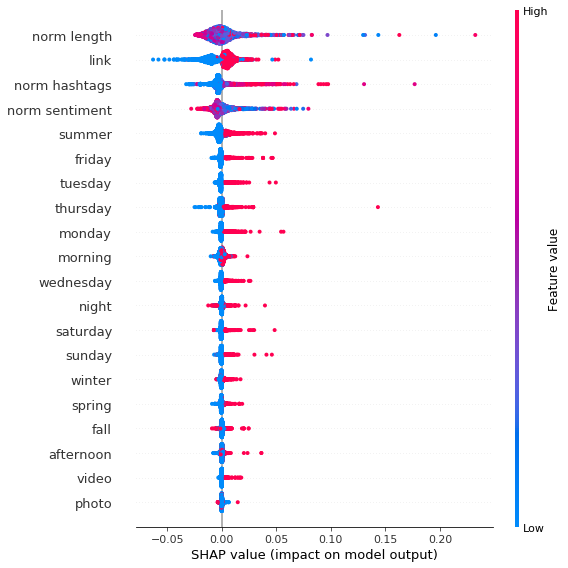

In [22]:
explainer = shap.TreeExplainer(rfr)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

### Random Forest Classifier

In [123]:
#defining classification criteria of "good" as a log normalized score greater than the 50th percentile and "bad" as the opposite
df4['class'] = df4['norm log score'].map(lambda x: 1 if (x >= .02358) else 0 )
df_labels = df4[['class']]
df_array = df_labels.loc[:,'class']
numbers = df_array.values 

array([0, 1, 1, ..., 0, 0, 0])

In [124]:
# define the model
rfc = RandomForestClassifier()
# fit the model
rfc.fit(X, numbers)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [125]:
explainer = shap.TreeExplainer(rfc)

In [126]:
shap_values = explainer.shap_values(X)

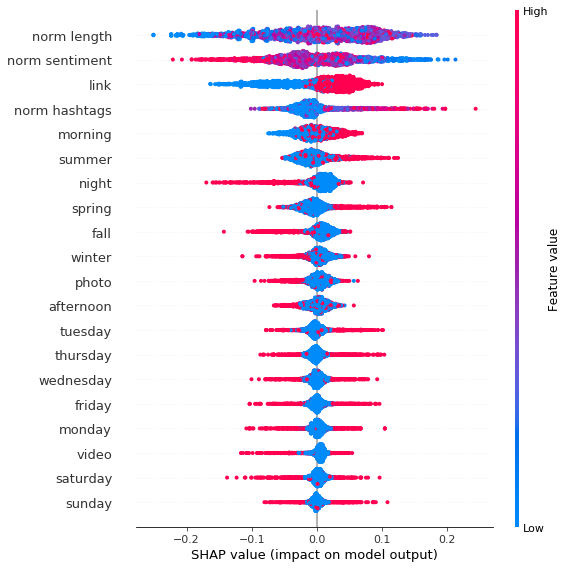

In [129]:
shap.summary_plot(shap_values[1], X)

In [43]:
df4['class2'] = df4['norm log score'].map(lambda x: 0 if (x < .012823) else 1 if (x >= .012823 and x <.038691) else 2 )
df_labels2 = df4[['class2']]
df_array2 = df_labels2.loc[:,'class2']
numbers2 = df_array2.values

In [114]:
# define the model
rfc2 = RandomForestClassifier()
# fit the model
rfc2.fit(X, numbers2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [66]:
explainer2 = shap.TreeExplainer(rfc2)

In [67]:
shap_values2 = explainer2.shap_values(X)

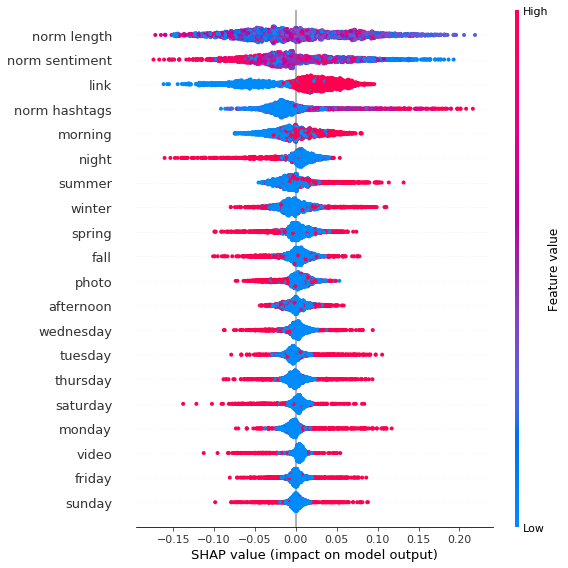

In [119]:
shap.summary_plot(shap_values2[2], X)

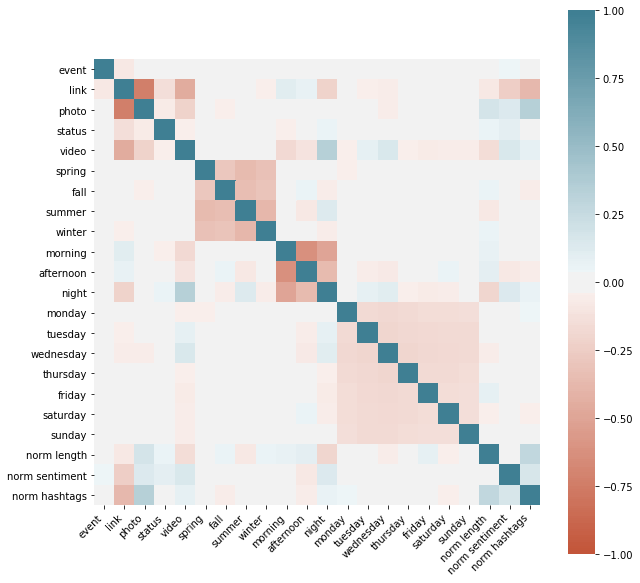

In [147]:
fig1, ax1 = plt.subplots(figsize=(10,10)) 

ax1 = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
    
)
ax1.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);